In [1]:
# importa a biblioteca do opencv
import cv2

def read_image(filename):
    # carrega a imagem colorida e transforma ela em uma matriz do numpy
    image = cv2.imread(filename)
    
    # calcula o pixel com menor intensidade
    # inicia a cor com o maior valor possivel
    color = 255 * 3

    # pega as dimensoes da imagem
    (rows, cols, depth) = image.shape

    # varre todos os pixels
    for row in range(rows):
        for col in range(cols):

            # acessa um pixel da imagem
            pixel     = image[row][col]
            (r, g, b) = pixel.tolist()

            if color > (r + g + b):
                color = r + g + b
                
    for row in range(rows):
        for col in range(cols):
            pixel = image[row][col]
            (r, g, b) = pixel.tolist()
            c = (r + g + b)

            # pinta de branco o que nao for letra
            if c != color:
                image[row][col] = (255, 255, 255)
            # pinta de preto o que for letra
            else:
                image[row][col] = (0, 0, 0)
                
                
    return image

In [2]:
def recursive_bounding(image, row, col, letter_color):

    min_x = col
    min_y = row

    max_x = col
    max_y = row

    (rows, cols, depth) = image.shape
    for r in range(    max(0, row - 1), min(row + 2, rows)):
        for c in range(max(0, col - 1), min(col + 2, cols)):
            if r == row and c == col:
                continue

            (r1, g1, b1) = image[r][c].tolist()
            t = (r1 + g1 + b1)

            # vizinho nao pertence a letra, ignora ele
            if t != letter_color:
                continue

            # apaga esse pixel
            # nao salvamos ele como branco pq precisaremos dele
            # no proximo processamento
            image[r][c] = (20, 20, 20)

            points = recursive_bounding(image, r, c, letter_color)
            (min_x1, max_x1, min_y1, max_y1) = points;

            min_x = min(min_x, min_x1, c)
            max_x = max(max_x, max_x1, c)
            min_y = min(min_y, min_y1, r)
            max_y = max(max_y, max_y1, r)

    return (min_x, max_x, min_y, max_y)

In [3]:
def compute_boxes(image):
    boxes = []
    letter_color = 0

    (rows, cols, depth) = image.shape
    
    for row in range(rows):
        for col in range(cols):
            pixel     = image[row][col]
            (r, g, b) = pixel.tolist();
            t = (r + g + b)

            # nao eh letra, ignora o pixel
            if t != letter_color:
                continue

            # calcula a bounding box dessa letra
            box = recursive_bounding(image, row, col, letter_color)

            # salva o bounding box numa lista de boxes
            boxes.append(box)

    boxes.sort()
    return boxes

In [4]:
def cut_boxes(image, boxes):
    letters = []

    for box in boxes:
        (col0, col1, row0, row1) = box

        letter = image[row0:row1 + 1, col0:col1 + 1]
        letters.append(letter)
        
    return letters

In [5]:
def break_captcha(letters, templates):
    captcha = ''
    unrec   = 0

    for letter in letters:

        (rows, cols, depth) = letter.shape
        best_error  = rows * cols
        best_letter = ''

        # copia a imagem, transformando de RGB para tons de cinza
        gray = cv2.cvtColor(letter, cv2.COLOR_RGB2GRAY)

        # binariza a imagem
        (_, gray) = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY);

        for letter in templates.keys():
            for template in templates[letter]:

                # se a imagem for de tamanho diferente do template
                # ignora o template
                if template.shape != gray.shape:
                    continue

                xor = template ^ gray

                errors = xor.sum()

                if errors < best_error:
                    best_error  = errors
                    best_letter = letter
                    
                    # match perfeito
                    if errors == 0:
                        break;
                        
            if best_error == 0:
                break;

        # nao casou exatamente com nenhuma letra
        # provavelmente eh uma nova letra
        if best_error != 0:
            cv2.imwrite("image_%d.png" % (unrec), gray)
            unrec = unrec + 1

        captcha = captcha + best_letter

    return captcha

In [6]:
import os
import glob
import collections

def load_templates():
    # filtra os arquivos .png
    files = glob.glob('templates/*.png')

    # dicionario com as imagens
    # chave = letra
    # valor = lista de imagem
    templates = collections.defaultdict(list)

    for file in files:
        f = os.path.basename(file)

        # o primeiro caracter do nome do arquivo eh a letra
        # correspondente
        letter = f[0]

        # carrega a imagem
        img = cv2.imread(file)

        # muda a imagem pra tons de cinza
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # binariza a imagem
        (_, img) = cv2.threshold(img, 245, 255, cv2.THRESH_BINARY)

        # uma letra pode ter varios templates
        templates[letter].append(img)

    return templates

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
file = 'a.png'

Imagem Original

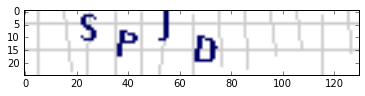

In [9]:
plt.imshow(cv2.imread(file))

Imagem Limpa e Binarizada

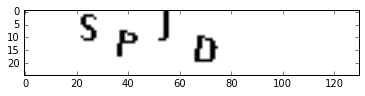

In [10]:
image = read_image(file)
plt.imshow(image)

Coordenadas das letras

In [11]:
boxes = compute_boxes(image)
boxes

[(22, 27, 2, 11), (36, 43, 8, 17), (52, 55, 0, 11), (66, 74, 10, 19)]

Letras recortadas

In [12]:
letters = cut_boxes(image, boxes)

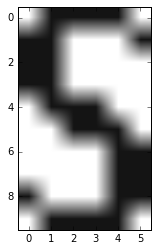

In [13]:
plt.imshow(letters[0], cmap='gray')

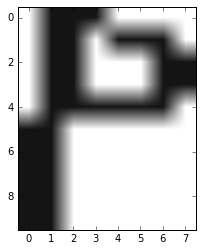

In [14]:
plt.imshow(letters[1], cmap='gray')

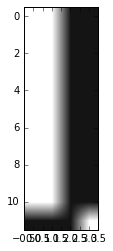

In [15]:
plt.imshow(letters[2], cmap='gray')

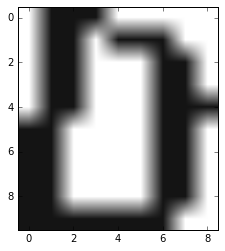

In [16]:
plt.imshow(letters[3], cmap='gray')

Carrega os templates

In [17]:
templates = load_templates()

Quebra o captcha

In [18]:
break_captcha(letters, templates)

'spjd'